In [1]:
! pip install -U neuraloperator

  Using cached neuraloperator-1.0.2-py3-none-any.whl.metadata (7.5 kB)
  Using cached wandb-0.19.9-py3-none-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (10 kB)
  Using cached configmypy-0.2.0-py3-none-any.whl.metadata (5.0 kB)
  Using cached tensorly-0.9.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached tensorly_torch-0.5.0-py3-none-any.whl.metadata (4.6 kB)
  Using cached torch_harmonics-0.7.3-py3-none-any.whl
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached pytest-8.3.5-py3-none-any.whl.metadata (7.6 kB)
  Using cached pytest_mock-3.14.0-py3-none-any.whl.metadata (3.8 kB)
  Using cached docker_pycreds-0.4.0-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached sentry_sdk-2.26.1-py2.py3-none-any.whl.metadata (10 kB)
  Using cached setproctitle-1.3.5-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (10 kB)
  Using cached iniconfig-2.1.0-py3-none-any.whl.metadata (2.7 kB)
Using cache

In [16]:
import numpy as np
import matplotlib.pyplot as plt


def solve_laplace(N, num_iter=2000):
    """
    Solve the steady-state Laplace equation on a square [0,1]^2
    with Dirichlet boundary conditions:
      phi = 0 on left, top, bottom; phi = 1 on right.
    Uses Jacobi iteration.
    """
    phi = np.zeros((N, N), dtype=np.float32)
    # Boundary conditions
    phi[:, -1] = 1.0  # right boundary = 1
    # phi[:, 0] = 0, phi[0, :] = 0, phi[-1, :] = 0 by init

    # Jacobi iteration
    for _ in range(num_iter):
        phi[1:-1, 1:-1] = 0.25 * (
            phi[1:-1, 2:] + phi[1:-1, :-2] +
            phi[2:, 1:-1] + phi[:-2, 1:-1]
        )
    return phi

def generate_data(num_samples=1000, num_iter=1000):
    """
    Returns three NumPy arrays of shape:
      high_res_solved:      (num_samples, 256,256)
      low_res_solved:       (num_samples,  64,64)
      low_res_coarsened:    (num_samples,  64,64)  # downsampled from high-res
    """
    high_res_list     = []
    low_res_list      = []
    low_coarse_list   = []

    for i in range(num_samples):
        if i% 100 == 0:
            print (i)
        # solve high-res (256×256)
        high = solve_laplace(256, num_iter=num_iter)
        # solve low-res reference (64×64)
        low  = solve_laplace(64,  num_iter=num_iter)
        # coarsen high-res to 64×64
        coarse = high[::4, ::4]

        # append into Python lists
        high_res_list.append(high)
        low_res_list.append(low)
        low_coarse_list.append(coarse)

    # stack into 3D arrays
    high_res_solved   = np.stack(high_res_list,   axis=0)
    low_res_solved    = np.stack(low_res_list,    axis=0)
    low_res_coarsened = np.stack(low_coarse_list, axis=0)

    return high_res_solved, low_res_solved, low_res_coarsened



0
100
200
300
400
500
600
700
800
900
High-res solved shape: (1000, 256, 256)
Low-res solved shape:  (1000, 64, 64)
Low-res shape:  (1000, 64, 64)


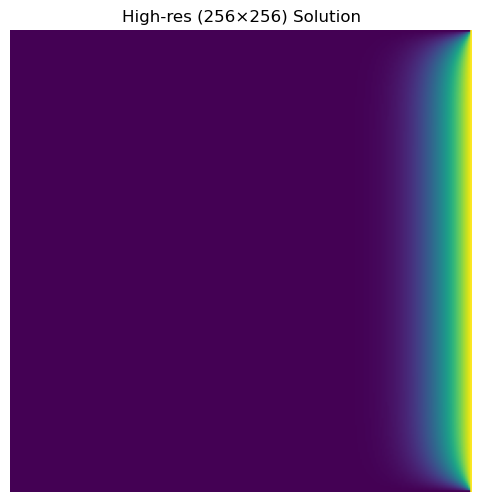

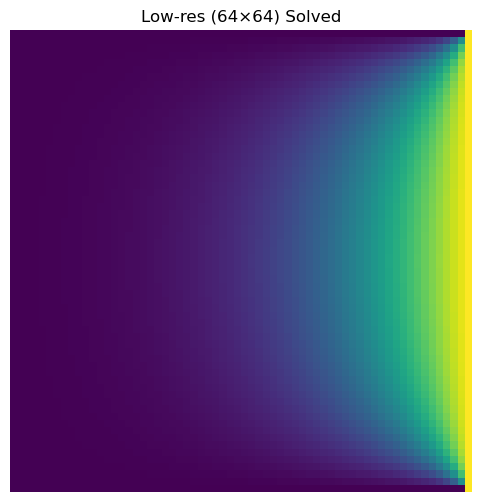

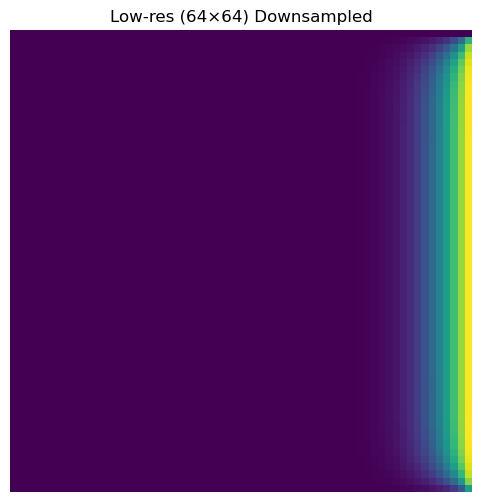


Saved both arrays to: /mnt/data/darcy_solutions.npz


In [17]:
high_res_solved, low_res_solved, low_res_coursened = generate_data()

# Save datasets for later use
np.savez('./darcy_solutions.npz', high_res=high_res_solved, low_res_solved=low_res_solved, low_res=low_res_coursened)

print("High-res solved shape:", high_res_solved.shape)
print("Low-res solved shape: ", low_res_solved.shape)
print("Low-res shape: ", low_res_coursened.shape)

# Plot high-resolution solution
plt.figure(figsize=(6, 6))
plt.imshow(high_res_solved[0])
plt.title("High-res (256×256) Solution")
plt.axis('off')
plt.show()

# Plot low-resolution solution
plt.figure(figsize=(6, 6))
plt.imshow(low_res_solved[0])
plt.title("Low-res (64×64) Solved")
plt.axis('off')
plt.show()

# Plot low-resolution solution
plt.figure(figsize=(6, 6))
plt.imshow(low_res_coursened[0])
plt.title("Low-res (64×64) Downsampled")
plt.axis('off')
plt.show()

# Provide download link
print("\nSaved both arrays to: /mnt/data/darcy_solutions.npz")


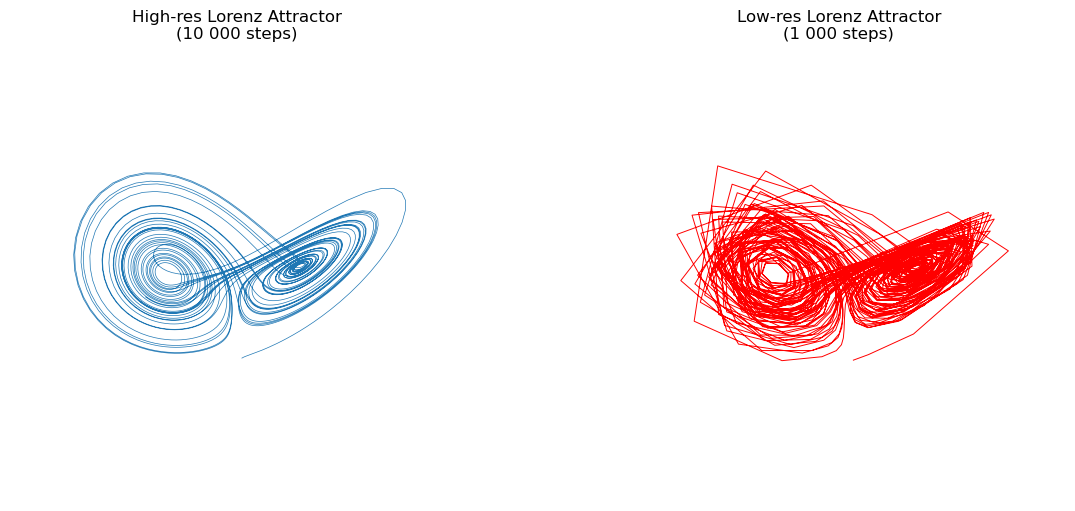

high_res.shape = (10000, 3)
low_res.shape  = (1000, 3)
Saved to 'lorenz_dataset.npz'


In [20]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_lorenz(num_steps=10000, dt=0.01,
                    sigma=10.0, beta=8/3, rho=28.0,
                    init_state=(1.0, 1.0, 1.0)):
    """Euler‐integrate the Lorenz ODE for num_steps at timestep dt."""
    x, y, z = init_state
    traj = np.zeros((num_steps, 3), dtype=np.float32)
    for i in range(num_steps):
        dx = sigma*(y - x)
        dy = x*(rho - z) - y
        dz = x*y - beta*z
        x, y, z = x + dt*dx, y + dt*dy, z + dt*dz
        traj[i] = (x, y, z)
    return traj

# --- Generate data ---
high_res = simulate_lorenz(num_steps=10000, dt=0.01)
low_res  = high_res[::10]   # downsample 10× → shape (1000,3)

# Save both to disk
np.savez('lorenz_dataset.npz', high_res=high_res, low_res=low_res)

# --- Visualize ---
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(constrained_layout=True, figsize=(12,5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(high_res[:5000,0], high_res[:5000,1], high_res[:5000,2], lw=0.5)
ax1.set_title("High-res Lorenz Attractor\n(10 000 steps)")
ax1.axis('off')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(low_res[:,0], low_res[:,1], low_res[:,2], lw=0.7, color='r')
ax2.set_title("Low-res Lorenz Attractor\n(1 000 steps)")
ax2.axis('off')

plt.show()

print("high_res.shape =", high_res.shape)
print("low_res.shape  =", low_res.shape)
print("Saved to 'lorenz_dataset.npz'")


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.fft
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from torch.utils.data import TensorDataset, DataLoader

def generate_sample(high_res=64, downsample_factor=4, sigma=2):
    """
    Generates a synthetic high-resolution turbulent-like field and a low-resolution version.
    
    Parameters:
      high_res (int): Resolution of the high-resolution field (e.g., 64 means a 64x64 grid).
      downsample_factor (int): Factor by which to downsample the high-res field.
      sigma (float): Standard deviation for Gaussian filter; controls smoothness.
    
    Returns:
      X: Low-resolution field (input) of shape (high_res/downsample_factor, high_res/downsample_factor).
      Y: High-resolution field (target) of shape (high_res, high_res).
    """
    # Generate a random field (which mimics raw turbulent fluctuations)
    field = np.random.randn(high_res, high_res)
    # Apply Gaussian filter to introduce spatial correlation (mimicking the effect of fluid diffusion)
    Y = gaussian_filter(field, sigma=sigma)
    # Downsample to get low-resolution input by taking every nth pixel in each direction
    X = Y[::downsample_factor, ::downsample_factor]
    return X, Y

# Define dataset sizes and resolutions
N_train = 1000
N_test = 200
high_res = 256
downsample_factor = 4  # This yields a low resolution of 64/4 = 16

# Allocate arrays for training data
X_train = []
Y_train = []
for i in range(N_train):
    x, y = generate_sample(high_res=high_res, downsample_factor=downsample_factor, sigma=2)
    X_train.append(x)
    Y_train.append(y)
X_train = np.array(X_train)  # Shape: (100, 16, 16)
Y_train = np.array(Y_train)  # Shape: (100, 64, 64)

# Allocate arrays for test data
X_test = []
Y_test = []
for i in range(N_test):
    x, y = generate_sample(high_res=high_res, downsample_factor=downsample_factor, sigma=2)
    X_test.append(x)
    Y_test.append(y)
X_test = np.array(X_test)   # Shape: (20, 16, 16)
Y_test = np.array(Y_test)   # Shape: (20, 64, 64)

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)


X_train shape: (1000, 64, 64)
Y_train shape: (1000, 256, 256)
X_test shape: (200, 64, 64)
Y_test shape: (200, 256, 256)


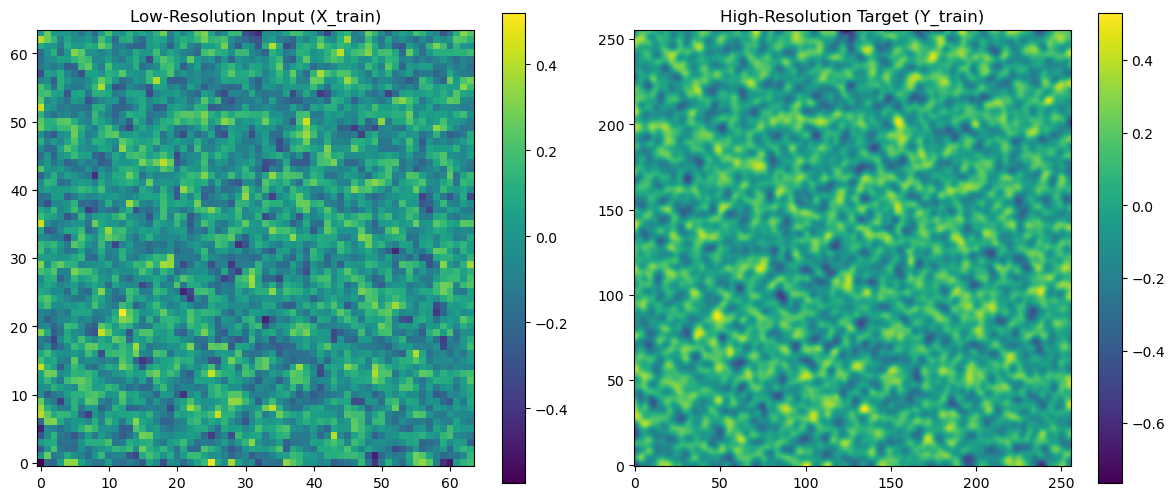

In [3]:
# Visualize a sample pair from the training set
sample_idx = 0  # Choose a sample from the training set

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Low-Resolution Input (X_train)")
plt.imshow(X_train[sample_idx], cmap='viridis', origin='lower')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("High-Resolution Target (Y_train)")
plt.imshow(Y_train[sample_idx], cmap='viridis', origin='lower')
plt.colorbar()

plt.tight_layout()
plt.show()


In [4]:
# Convert NumPy arrays to torch tensors and add channel dimensions
# Low-resolution inputs have shape (batch, 1, 16, 16)
# High-resolution targets have shape (batch, 1, 64, 64)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32).unsqueeze(1)

# Create PyTorch DataLoaders
batch_size = 5
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset  = TensorDataset(X_test_tensor, Y_test_tensor)
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader   = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
import torch
import torch.optim as optim
from tqdm import tqdm
from neuralop.models import FNO

device = torch.device("cpu")

# Instantiate the FNO model.
fno_model = FNO(
    n_modes=(12, 12),
    in_channels=1,
    out_channels=1,
    hidden_channels=8,
    n_layers=4,
    resolution_scaling_factor=4,  # maps 64x64 -> 256x256
    positional_embedding="grid",
)
# Move the model to device and convert to half precision.
fno_model = fno_model.to(device)

optimizer_fno = optim.Adam(fno_model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()  # MSELoss supports FP16

epochs = 20

#scaler = torch.cuda.amp.GradScaler('cuda')

for epoch in range(epochs):
    fno_model.train()
    epoch_loss = 0.0
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        # Move data to device and cast to FP16.
        #x, y = x.to(device).half(), y.to(device).half()
        optimizer_fno.zero_grad()
        # Use the new autocast syntax.
        pred = fno_model(x)  # Prediction: shape (batch, 64, 64) or (batch, 256, 256) depending on your settings
        loss = criterion(pred, y.squeeze(1))
        scaler.scale(loss).backward()
        scaler.step(optimizer_fno)
        scaler.update()
        epoch_loss += loss.item() * x.size(0)
    epoch_loss /= len(train_dataset)
    print(f"Epoch {epoch+1}/{epochs} FNO Loss: {epoch_loss:.5f}")

# Evaluate FNO on test data
fno_model.eval()
with torch.no_grad():
    test_loss = 0.0
    for x, y in tqdm(test_loader, desc="Evaluating", leave=False):
        #x, y = x.to(device).half(), y.to(device).half()
        pred = fno_model(x)
        loss = criterion(pred, y.squeeze(1))
        test_loss += loss.item() * x.size(0)
    test_loss /= len(test_dataset)
print(f"FNO Test Loss: {test_loss:.5f}")


Epoch 1/20:   0%|          | 0/200 [00:00<?, ?it/s]